### **Análise de Tweets**



In [1]:
import tweepy 
import pandas as pd     
import numpy as np 
import matplotlib.pyplot as plt
from textblob import TextBlob as tb

**Autenticação no Twitter**

In [2]:
# Credenciais para utilização da API do Twitter

API_key = ""
API_secret_key = ""
Access_token = ""
Access_token_secret = ""

In [3]:
#Realizar autenticação no Twitter

auth = tweepy.OAuthHandler(API_key,API_secret_key)
auth.set_access_token(Access_token,Access_token_secret)

# Construct the API instance
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True,
                 retry_count=5,retry_delay=10)

**Coleta dos Dados**     
Palavra-chave: máscara

In [4]:
# Definir listas de armazenamento
tweets = []
info = []

In [5]:
#Definir que palavras (keyword) que deseja pesquisar no Twitter
keyword = ("máscara")

In [6]:
for tweet in tweepy.Cursor(api.search,
                           q=keyword, tweet_mode='extended',
                           rpp=200, result_type="recent",lang='pt', 
                           include_entities=True).items(200):
        
    if 'retweeted_status' in dir(tweet): # Check if Retweet
        # If status is a Retweet, status.full_text (tweet.full_text) could be truncated.
        # We should get retweeted_status.full_text
        aux=tweet.retweeted_status.full_text       
    else: # Not a Retweet
        aux=tweet.full_text
        
    newtweet = aux.replace("\n", " ")
   
    tweets.append(newtweet)
    info.append(tweet) 

In [7]:
# Verifica a quantidade de tweets coletados 

print("Total de tweets coletados %s." % (len(info)))

Total de tweets coletados 200.


In [8]:
# cria um df
tweets_df = pd.DataFrame(tweets, columns=['Tweets']) 

tweets_df['len']  = np.array([len(tweet) for tweet in tweets])
tweets_df['ID']   = np.array([tweet.id for tweet in info])
tweets_df['USER']   = np.array([tweet.user.screen_name for tweet in info])
tweets_df['userName'] = np.array([tweet.user.name for tweet in info])
tweets_df['User Location']    = np.array([tweet.user.location for tweet in info])
tweets_df['Language'] = np.array([tweet.user.lang for tweet in info])
tweets_df['Date'] = np.array([tweet.created_at for tweet in info])
tweets_df['Source'] = np.array([tweet.source for tweet in info])
tweets_df['Likes']  = np.array([tweet.favorite_count for tweet in info])
tweets_df['Retweets']    = np.array([tweet.retweet_count for tweet in info])
tweets_df['Geo']    = np.array([tweet.geo for tweet in info])
tweets_df['Coordinates']    = np.array([tweet.coordinates for tweet in info])         
tweets_df['Place']    = np.array([tweet.place for tweet in info])

tweets_df.to_csv("tweets_keyword_homeoffice.csv")

In [9]:
# verifica os dados no df
tweets_df.head()

,Tweets,len,ID,USER,userName,User Location,Language,Date,Source,Likes,Retweets,Geo,Coordinates,Place
0,"Eu: moço, coloca a máscara, por favor? Uber: s...",274,1312758758397882368,Andressagomeszz,diaba loira,"São José dos Pinhais, Brasil",None,2020-10-04 14:17:32,Twitter for Android,0,23943,None,None,None
1,pfv normalizem a mascara depois da pandemia eu...,91,1312758754413367296,inthwexpect,may,,None,2020-10-04 14:17:31,Twitter for Android,0,1273,None,None,None
2,"Lembrando que hj, as 16h, teremos uma conversa...",222,1312758753213775872,profagraciele,Professora Graciele,"Sinop, Brasil",None,2020-10-04 14:17:31,Twitter for iPhone,0,0,None,None,None
3,sorrir de máscara achando que a pessoa ta vend...,103,1312758751464751104,Oliiveira_12,CH,"Triagem , Rio De Janeiro",None,2020-10-04 14:17:30,Twitter for Android,0,4682,None,None,None
4,o bom eh que se tiver de máscara não embaça a ...,75,1312758738332323840,loisgustavu,ᛚ ᚢ ᛁ ᛊ,,None,2020-10-04 14:17:27,Twitter for Android,0,2786,None,None,None


In [10]:
tweets_df.shape

(200, 14)

**Top Tweets**

In [11]:
# Tweets com maior número de LIKES
likes_max = np.max(tweets_df['Likes']) 
likes = tweets_df[tweets_df.Likes == likes_max].index[0] 

print("O tweet com mais curtidas (likes) é: \n{}".format(tweets_df['Tweets'][likes]))
print("Número de curtidas: {}".format(likes_max))

O tweet com mais curtidas (likes) é: 
mano a praia de madrugada tava LOTADA e tudo por causa desse suposto "luau" q fizeram mds q raiva e todo mundo tava sem máscara vei
Número de curtidas: 3


In [12]:
#conta quantos tweets possuem o mesmo valor máximo de curtidas
print(np.sum(tweets_df['Likes'] == likes_max)) 

1


In [13]:
# Tweets com maior número de RTs
retweet_max  = np.max(tweets_df['Retweets']) 
retweet  = tweets_df[tweets_df.Retweets == retweet_max].index[0]

print("O tweet com mais retweet é: \n{}".format(tweets_df['Tweets'][retweet]))
print("Número de retweets: {}".format(retweet_max))

O tweet com mais retweet é: 
Eu: moço, coloca a máscara, por favor? Uber: senhora, calma, não é pra tanto Eu: moço, sou médica, trabalho em CTI da Covid e to tentando proteger você. Tinham uns 20 hj lá  Colocou a máscara em 1/2 segundo. Uma nova vida baseada em aterrorizar pra proteger  Sou médica nada
Número de retweets: 23943


In [14]:
#conta quantos tweets possuem o mesmo valor máximo de Retweets
print(np.sum(tweets_df['Retweets'] == retweet_max)) 

4


**Origem do tweet (dispositivo ou app)**

In [15]:
sources = [] #lista para armazenar a fontes
for source in tweets_df['Source']:
    if source not in sources:
        sources.append(source) #inclui no vetor sources apenas se a fonte encontrada ainda não foi incluída

percent = np.zeros(len(sources)) #Retorna um novo vetor, com o número de elementos do vetor sources, preenchido com zeros a new array filled with zeros, for

for source in tweets_df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

In [16]:
sourceDF = pd.DataFrame({
 'source':percent,
}, index=sources)

sourceDF.head()

,source
Twitter for Android,129.0
Twitter for iPhone,48.0
Twitter Web App,21.0
TweetDeck,1.0
Twitter for Mac,1.0


In [17]:
#Excluir quando o número de tweets da fonte for  < 10
sourceDF = sourceDF.drop(sourceDF[sourceDF.source < 10].index)

sourceDF

,source
Twitter for Android,129.0
Twitter for iPhone,48.0
Twitter Web App,21.0


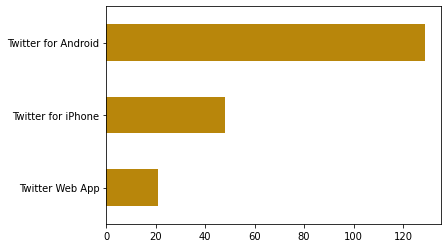

In [18]:
sources_sorted = sourceDF.sort_values('source')
ax = sources_sorted.source.plot(kind='barh',color='#B8860B')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

**Análise temporal**

In [19]:
from datetime import datetime

In [20]:
data = tweets_df.copy()
print(data['Date'][0])

2020-10-04 14:17:32


In [21]:
# Converte a data para apenas dia/mês e ano
data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.date())
print(data['Date'][0])

2020-10-04


In [22]:
#Quantidade de Tweets por dia
QtdeDiaria = data['Date'].value_counts() 
QtdeDiaria

2020-10-04    200
Name: Date, dtype: int64

**Análise de Polaridade**

In [ ]:
# !pip install googletrans
# !pip install unidecode

In [24]:
from googletrans import Translator
from unidecode import unidecode

In [25]:
#Calcula a polaridade do texto traduzido

analysis = None
polarities = []

for tweet in tweets_df['Tweets']: 
    #Texto do Tweet
    textPT = unidecode(tweet)
    
    #Traduz para o Inglês
    textEN = Translator().translate(textPT)
    
    analysis = tb(textEN.text)    
    polarity = analysis.sentiment.polarity   
    polarities.append(polarity)


**Análise de sentimentos**

In [26]:
print('Para a(s) palavra(s):"%s"' % keyword)
print('A MÉDIA DE SENTIMENTO É: ' + str(np.mean(polarities)))

Para a(s) palavra(s):"máscara"
A MÉDIA DE SENTIMENTO É: 0.18788907828282825


In [27]:
positive = 0
negative = 0
neutral = 0

for polarity in polarities:
    if polarity > 0:
        positive = positive+1
    elif polarity < 0:
        negative = negative+1
    else:
        neutral = neutral+1
        
print("Tweets Positivos: %s" % positive)
print("Tweets Negativos: %s" % negative)
print("Tweets Neutros: %s" % neutral)

# Calcula percentual
pos_pct=positive*100/len(polarities)
neg_pct=negative*100/len(polarities)
neu_pct=neutral*100/len(polarities)

Tweets Positivos: 129
Tweets Negativos: 22
Tweets Neutros: 49


In [28]:
# Define variáveis
sentiments = ['Positivos', 'Negativos','Neutros']
percents = [pos_pct, neg_pct, neu_pct]

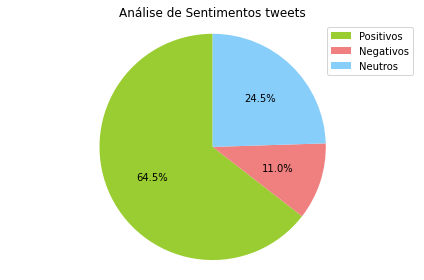

In [29]:
# plota o gráfico de análise

colors = ['yellowgreen', 'lightcoral', 'lightskyblue'] #Personalizar as cores

plt.pie(percents,colors=colors , autopct='%1.1f%%', startangle=90)
plt.legend(sentiments, loc="best")
plt.title("Análise de Sentimentos tweets")
plt.axis('equal')
plt.tight_layout()
plt.show()                

**Mapa dos tweets**

In [30]:
from geopy.geocoders import Nominatim
import folium
from folium import plugins

In [31]:
geolocator = Nominatim(user_agent="TwitterSentimentAnalysis")

# armazena a latitude e a longitude
latitude = []
longitude = []

for user_location in tweets_df['User Location']:
    try:
        location = geolocator.geocode(user_location) 
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        continue

In [32]:
coordenadas = np.column_stack((latitude, longitude))

mapa = folium.Map(zoom_start=3)
mapa.add_child(plugins.HeatMap(coordenadas))
mapa.save('mapa_calor_tweets.html')
mapa

**Nuvem de Palavras**

In [33]:
import re
import string
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.simplefilter('ignore')

In [34]:
words = ' '.join(tweets_df['Tweets'])

In [35]:
# Limpeza dos dados
words = words.lower() # minúsculas
words = re.sub(r'[?|$|.|:|!|"|,]',r'',words) #remove pontuação
words = re.sub('[0-9]+', '', words) #remove números
words = re.sub(r'@\S+', '', words) # remove mentions ou menções
words = re.sub(r'#\S+', '', words) # remove hashtags
words = re.sub(r"http\S+", "", words) # remove hyperlinks

In [36]:
words_clean = " ".join([word for word in words.split()
                            if word != 'RT'
                            ])

In [37]:
stopwords = ["da", "do", "na", "no", "meu", "em", "das", 
             "de", "ao", "os", "as", "se", "que", "não", 
             "pra", "para", "por", "com", "me", "há"]

In [38]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100,
                      background_color='black', width=1600,                            
                      height=800, collocations=False).generate(words_clean)

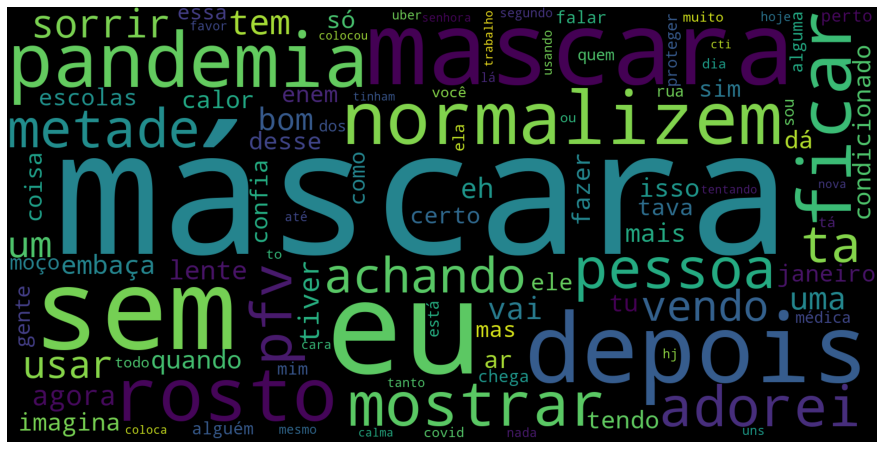

In [39]:
# plota a word cloud de Sertanejo
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.savefig('tweets_wordcloud.png', dpi=150)
plt.imshow(wordcloud)



---



**Referências:**    

* http://docs.tweepy.org/en/v3.5.0/api.html    
* https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json
* https://textblob.readthedocs.io/en/dev/#    
* https://pypi.org/project/geopy/   
* https://python-visualization.github.io/folium/  
* https://pypi.org/project/wordcloud/



In [40]:
# Author: Priscilla Bomfim (@priscillapreks)
# Data: 03.10.2020